In [12]:
import os
import subprocess

import numpy as np
import pandas as pd
import scipy.stats as sps
from tqdm import tqdm
from bed_reader import open_bed
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set(style="whitegrid", context="notebook", palette="pastel")

import warnings
warnings.simplefilter('ignore')

1. [plink LD arguments](https://www.cog-genomics.org/plink/1.9/ld):
    - **window size** - a window size in variant count or kilobase units
    - **step size** - a variant count to shift the window at the end of each step
    - **r2 thresold** - a pairwise r2 threshold: at each step, pairs of variants in the current window with squared correlation greater than the threshold are noted, and variants are greedily pruned from the window until no such pairs remain

In [3]:
PLINK_PATH = '/bin/plink'
DATA_PATH = 'data'

PREFIX = 'biengi'

# WC arguments
MAF_THRESHOLD = 0.05

# Prunning argument
LD_WINDOW = 150
LD_STEP = 10
LD_R2_THRESHOLD = 0.2

## Quality Control and Prunning

In [3]:
# QC + prunning with plink
QC_cmd = (
    f"{PLINK_PATH} "
    f"--bfile {DATA_PATH}/{PREFIX} "
    f"--indep-pairwise {LD_WINDOW} {LD_STEP} {LD_R2_THRESHOLD} "
    f"--maf {MAF_THRESHOLD} "
    f"--make-bed "
    f"--out {DATA_PATH}/{PREFIX}_clean"
)

# Prunning
prune_cmd = (
    f"{PLINK_PATH} "
    f"--bfile {DATA_PATH}/{PREFIX}_clean "
    f"--extract {DATA_PATH}/{PREFIX}_clean.prune.out "
    f"--make-bed "
    f"--out {DATA_PATH}/{PREFIX}_prunned"
)

In [4]:
subprocess.run(QC_cmd, shell=True)
subprocess.run(prune_cmd, shell=True)

PLINK v1.90b7.4 64-bit (18 Aug 2024)           www.cog-genomics.org/plink/1.9/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to data/biengi_clean.log.
Options in effect:
  --bfile data/biengi
  --indep-pairwise 150 10 0.2
  --maf 0.05
  --make-bed
  --out data/biengi_clean

96550 MB RAM detected; reserving 48275 MB for main workspace.
242180 variants loaded from .bim file.
894 people (574 males, 320 females) loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 894 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.999006.
7474 variants removed due to minor allele threshold(s)
(--maf/--max-maf/--mac/--max-mac).
234706 variants and 894 people pass filters and QC.
Note: N

CompletedProcess(args='/bin/plink --bfile data/biengi_clean --extract data/biengi_clean.prune.out --make-bed --out data/biengi_prunned', returncode=0)

## Read preprocessed data

In [4]:
# table with population annotation
data_pop = pd.read_csv(f'{DATA_PATH}/{PREFIX}.pedind', sep='\t', names=['c1', 'c2', 'c3', 'c4', 'c5', 'Population'])

# .bed file 
data_nf = open_bed(f'{DATA_PATH}/{PREFIX}_clean.bed').read()
data = open_bed(f'{DATA_PATH}/{PREFIX}_prunned.bed').read()

In [5]:
print(f'Number of samples: {data.shape[0]}')
print(f'Number of SNPs after prunning and QC: {data.shape[1]} ({round(100 * data.shape[1] / data_nf.shape[1], 2)})')
print(f'Number of populations: {data_pop['Population'].nunique()}')

Number of samples: 894
Number of SNPs after prunning and QC: 159276 (67.86)
Number of populations: 28


## Imputation

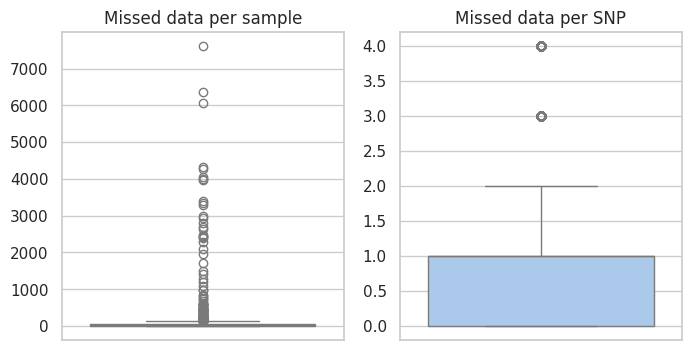

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

sns.boxplot(np.isnan(data).sum(axis=1), ax=axs[0])
sns.boxplot(np.isnan(data).sum(axis=0), ax=axs[1])

axs[0].set_title('Missed data per sample')
axs[1].set_title('Missed data per SNP');

Impute by SNP with mode

In [7]:
# Calculate the mode for each SNP
SNP_mode = sps.mode(data, axis=0, nan_policy='omit').mode[0]

# Impute missing values in each column with the mode
data_imputed = np.where(np.isnan(data), SNP_mode, data)

In [8]:
assert np.isnan(data_imputed).sum()==0, 'You failed'

## Run PCA

Find the best number of components - **Elbow method**

In [9]:
# explained_variance_ratios = []

# for k in tqdm(range(1, 31), colour='GREEN'):
#     pca = PCA(n_components=k)
#     data_transformed = pca.fit_transform(data_imputed)
#     explained_variance_ratios.append(pca.explained_variance_ratio_.sum().item()) # .explained_variance_

In [10]:
# plt.figure(figsize=(8, 4))
# plt.plot(range(1, 31), explained_variance_ratios)
# plt.scatter(range(1, 31), explained_variance_ratios)
# plt.xlabel('Number of components')
# plt.ylabel('Explained ratio');

Very low explained ratio... Okay, run with 10 components, btw we'll plot only 2-3 components

In [13]:
pca = PCA(n_components=20)
data_transformed = pca.fit_transform(data_imputed)

data_transformed.shape

(894, 20)

In [14]:
pca.explained_variance_ratio_.sum()

np.float64(0.08636912726721464)

## Plot main components

In [26]:
def plot_2d(data: pd.DataFrame, title: str, x: str = 'PC1', y: str = 'PC2', save_name: str = None):
    fig = px.scatter(
        data, 
        x=x, y=y, 
        color='Population',
        title=title,
        labels={x: 'Component 1', y: 'Component 2'},
        opacity=0.8,
        symbol='Population',
    )
    
    fig.update_traces(marker=dict(size=8, line=dict(color='black', width=1)))

    fig.update_layout(
        legend=dict(
            title="Population",
            x=1.05, y=1,
            bgcolor="rgba(255, 255, 255, 0.8)",
            orientation="h",
        ),
        margin=dict(l=0, r=0, b=0, t=30),
        xaxis_title=x,
        yaxis_title=y,
    )

    # fig.show()

    if save_name is not None:
        fig.write_html(f"{save_name}.html")

In [27]:
def plot_3d(data: pd.DataFrame, title: str, x: str = 'PC1', y: str = 'PC2', z: str = 'PC3', save_name: str = None):
    fig = px.scatter_3d(
        data, 
        x=x, y=y, z=z,
        color='Population',
        title=title,
        opacity=0.8,  
        symbol='Population',
    )
    
    fig.update_traces(marker=dict(size=4))
    
    fig.update_layout(
        scene=dict(
            xaxis_title=x,
            yaxis_title=y,
            zaxis_title=z
        ),
        legend=dict(
            title="Population",
            x=1.05, y=1,
            bgcolor="rgba(255, 255, 255, 0.8)",
        ),
        margin=dict(l=0, r=0, b=0, t=30)
    )
    
    # fig.show()

    if save_name is not None:
        fig.write_html(f"{save_name}.html")

In [28]:
data_pca = pd.DataFrame({'PC1': data_transformed[:, 0],
                         'PC2': data_transformed[:, 1],
                         'PC3': data_transformed[:, 2],
                         'Population': data_pop['Population'].values
                        })

data_pca.sample(5)

,PC1,PC2,PC3,Population
661,80.110577,4.409540,-2.792592,Tuva
511,24.622558,15.556147,-7.891584,Uzbek
21,-37.960733,-25.969672,-10.777654,Karel
859,98.103568,5.285055,-9.776828,Yakut
420,-39.722379,30.593688,11.811238,Karachay


1. [2d_pca](https://html-preview.github.io/?url=https://github.com/ksumarshmallow/MentorSem/blob/main/Ethnicity/biengi_2d_PCA.html)
2. [3d_pca](https://html-preview.github.io/?url=https://github.com/ksumarshmallow/MentorSem/blob/main/Ethnicity/biengi_3d_PCA.html)

In [29]:
plot_2d(data=data_pca, title='PCA Scatter Plot by Population', x='PC1', y='PC2', save_name=f"{PREFIX}_2d_PCA")

In [31]:
plot_3d(data=data_pca, title='PCA Scatter Plot by Population', x='PC1', y='PC2', z='PC3', save_name=f"{PREFIX}_3d_PCA")

## t-SNE
Запустим t-SNE на первых 20 компонентах из PCA

In [32]:
tsne_2 = TSNE(n_components=2, random_state=17)
tsne_3 = TSNE(n_components=3, random_state=17)

In [33]:
%%time
data_transformed_tsne_2 = tsne_2.fit_transform(data_transformed)
data_transformed_tsne_3 = tsne_3.fit_transform(data_transformed)

CPU times: user 50.9 s, sys: 41.6 ms, total: 50.9 s
Wall time: 3.24 s


In [34]:
data_tsne_2 = pd.DataFrame({'D1': data_transformed_tsne_2[:, 0],
                            'D2': data_transformed_tsne_2[:, 1],
                            'Population': data_pop['Population'].values
                        })

data_tsne_3 = pd.DataFrame({'D1': data_transformed_tsne_3[:, 0],
                            'D2': data_transformed_tsne_3[:, 1],
                            'D3': data_transformed_tsne_3[:, 2],
                            'Population': data_pop['Population'].values
                        })

data_tsne_2.sample(5)

,D1,D2,Population
438,-8.436056,32.362080,Abkhaz
601,25.052193,-18.351667,Khanty
749,18.402657,1.974951,Kazakh
203,-17.908714,24.694910,Chechen
364,-8.480662,-20.650379,Komi


1. [2d_tsne](https://html-preview.github.io/?url=https://github.com/ksumarshmallow/MentorSem/blob/main/Ethnicity/biengi_2d_TSNE.html)
2. [3d_tsne](https://html-preview.github.io/?url=https://github.com/ksumarshmallow/MentorSem/blob/main/Ethnicity/biengi_3d_TSNE.html)

In [35]:
plot_2d(data=data_tsne_2, title='t-SNE Scatter Plot by Population', x='D1', y='D2', save_name=f"{PREFIX}_2d_TSNE")

In [36]:
plot_3d(data=data_tsne_3,  title='t-SNE Scatter Plot by Population', x='D1', y='D2', z='D3', save_name=f"{PREFIX}_3d_TSNE")

### UMAP
Также запустим на 20 компонентах PCA

In [40]:
%%time
umap_2 = umap.UMAP(n_neighbors=30, n_components=2, metric='euclidean', random_state=17)
umap_3 = umap.UMAP(n_neighbors=30, n_components=3, metric='euclidean', random_state=17)

data_transformed_umap_2 = umap_2.fit_transform(data_transformed)
data_transformed_umap_3 = umap_3.fit_transform(data_transformed)

CPU times: user 5.51 s, sys: 2.96 ms, total: 5.52 s
Wall time: 3.64 s


In [41]:
data_umap_2 = pd.DataFrame({'D1': data_transformed_umap_2[:, 0],
                            'D2': data_transformed_umap_2[:, 1],
                            'Population': data_pop['Population'].values
                        })

data_umap_3 = pd.DataFrame({'D1': data_transformed_umap_3[:, 0],
                            'D2': data_transformed_umap_3[:, 1],
                            'D3': data_transformed_umap_3[:, 2],
                            'Population': data_pop['Population'].values
                        })

data_umap_2.sample(5)

,D1,D2,Population
705,9.456152,-11.148211,Buryat
234,4.962045,16.435558,Adygei
733,7.495175,-10.422999,Kazakh
32,18.775007,-1.786860,Moldovan
461,27.472889,-0.311621,Udmurt


In [42]:
plot_2d(data=data_tsne_2, title='UMAP Scatter Plot by Population', x='D1', y='D2', save_name=f"{PREFIX}_2d_UMAP")

In [44]:
plot_3d(data=data_tsne_3, title='UMAP Scatter Plot by Population', x='D1', y='D2', z='D3', save_name=f"{PREFIX}_3d_UMAP")

# 2. Admixure

### Run

In [24]:
ADMIXURE_PATH = '~/common/admixture/dist/admixture_linux-1.3.0/admixture'
K = 5     # ancestries count

In [25]:
admixure_cmd = f'{ADMIXURE_PATH} {DATA_PATH}/{PREFIX}_prunned.bed {K}'
subprocess.run(admixure_cmd, shell=True)

****                   ADMIXTURE Version 1.3.0                  ****
****                    Copyright 2008-2015                     ****
****           David Alexander, Suyash Shringarpure,            ****
****                John  Novembre, Ken Lange                   ****
****                                                            ****
****                 Please cite our paper!                     ****
****   Information at www.genetics.ucla.edu/software/admixture  ****

Random seed: 43
Point estimation method: Block relaxation algorithm
Convergence acceleration algorithm: QuasiNewton, 3 secant conditions
Point estimation will terminate when objective function delta < 0.0001
Estimation of standard errors disabled; will compute point estimates only.
Size of G: 894x159276
Performing five EM steps to prime main algorithm
1 (EM) 	Elapsed: 11.179	Loglikelihood: -1.61995e+08	(delta): 5.4647e+07
2 (EM) 	Elapsed: 11.234	Loglikelihood: -1.58192e+08	(delta): 3.80227e+06
3 (EM) 	Elapsed: 

CompletedProcess(args='~/common/admixture/dist/admixture_linux-1.3.0/admixture data/biengi_prunned.bed 5', returncode=0)

### Read results

In [29]:
data_admixure = pd.read_csv(f'{PREFIX}_prunned.{K}.Q', names=[1, 2, 3, 4, 5], sep=' ')
data_admixure = data_admixure.sort_values([1, 2, 3, 4, 5])
data_admixure.head()

,1,2,3,4,5
714,0.00001,0.00001,0.00001,0.00001,0.99996
715,0.00001,0.00001,0.00001,0.00001,0.99996
716,0.00001,0.00001,0.00001,0.00001,0.99996
717,0.00001,0.00001,0.00001,0.00001,0.99996
718,0.00001,0.00001,0.00001,0.00001,0.99996


## Admixure plot

In [32]:
def plot_ancestry(df: pd.DataFrame, df_pop: pd.DataFrame, target_populations: list, xlabel=True):
    """
    Arguments: 
      df - pd.DataFrame object with proportions of ancestries, [n_individuals, n_ancetries]
      df_pop - pd.DataFrame object with ethnicity assignment, [n_individuals, n_populations]
      target_populations: list of target populations from df_pop to plot proportions of ancestries
    """
    populations = df_pop.Population.values
    df_pop = df_pop[np.isin(populations, target_populations)]
    df = df.loc[df_pop.index]
    df = df.sort_values([1, 2, 3, 4, 5])

    plt.figure(figsize=(20, 4))

    bottom = np.zeros(df.shape[0])
    colors = sns.color_palette("Set2", n_colors=df.shape[1])
    for h in range(df.shape[1]):
        plt.bar(x = np.arange(df.shape[0]), height = df[h+1].values, bottom=bottom, 
                width=1, edgecolor='none', color=colors[h], label=f'Ancestry {h+1}')
        bottom += df[h+1].values
    
    # step = 5
    if xlabel:
        ax = plt.gca()
        ax.set_xticks(np.arange(0, len(df)))
        ax.set_xticklabels(df.index, rotation=90)  
    
        plt.xlim(0, df.shape[0])
        plt.ylim(0, 1)
        
        plt.legend(bbox_to_anchor=(0.5, 1.3), loc='upper center', ncol=5)
        plt.xlabel('Individual')
        plt.ylabel('Proportion')
        plt.title(", ".join(target_populations))
        
    plt.grid(False)

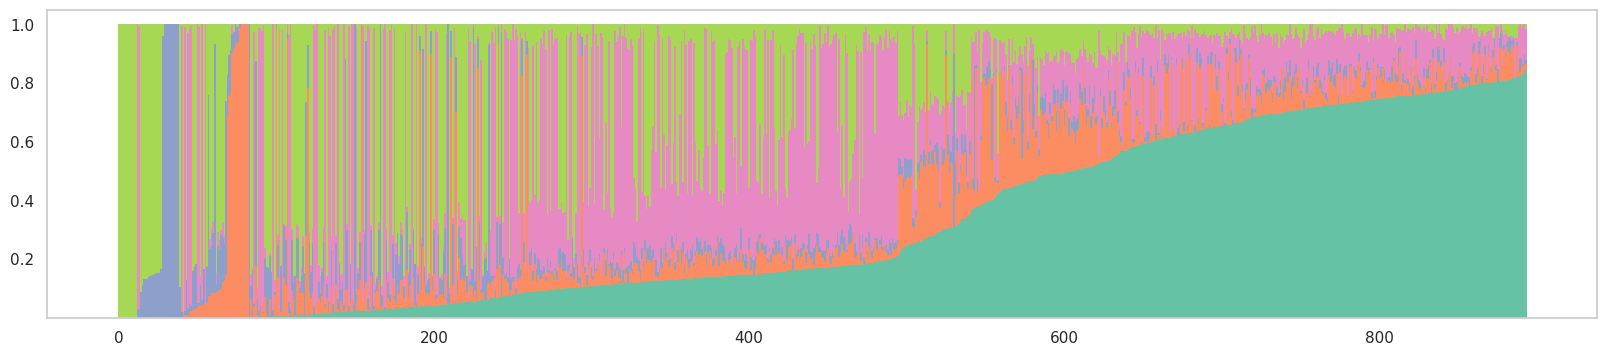

In [33]:
plot_ancestry(df=data_admixure, df_pop=data_pop, target_populations=data_pop.Population.unique(), xlabel=False)

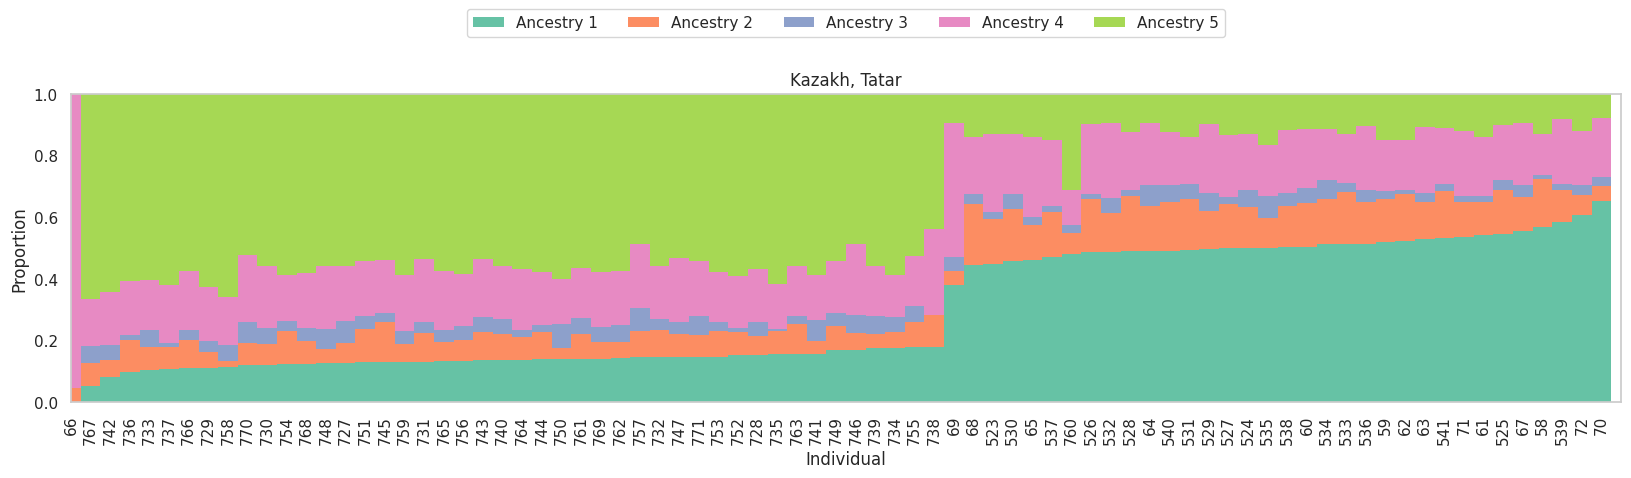

In [34]:
plot_ancestry(df=data_admixure, df_pop=data_pop, target_populations=['Kazakh', 'Tatar'])

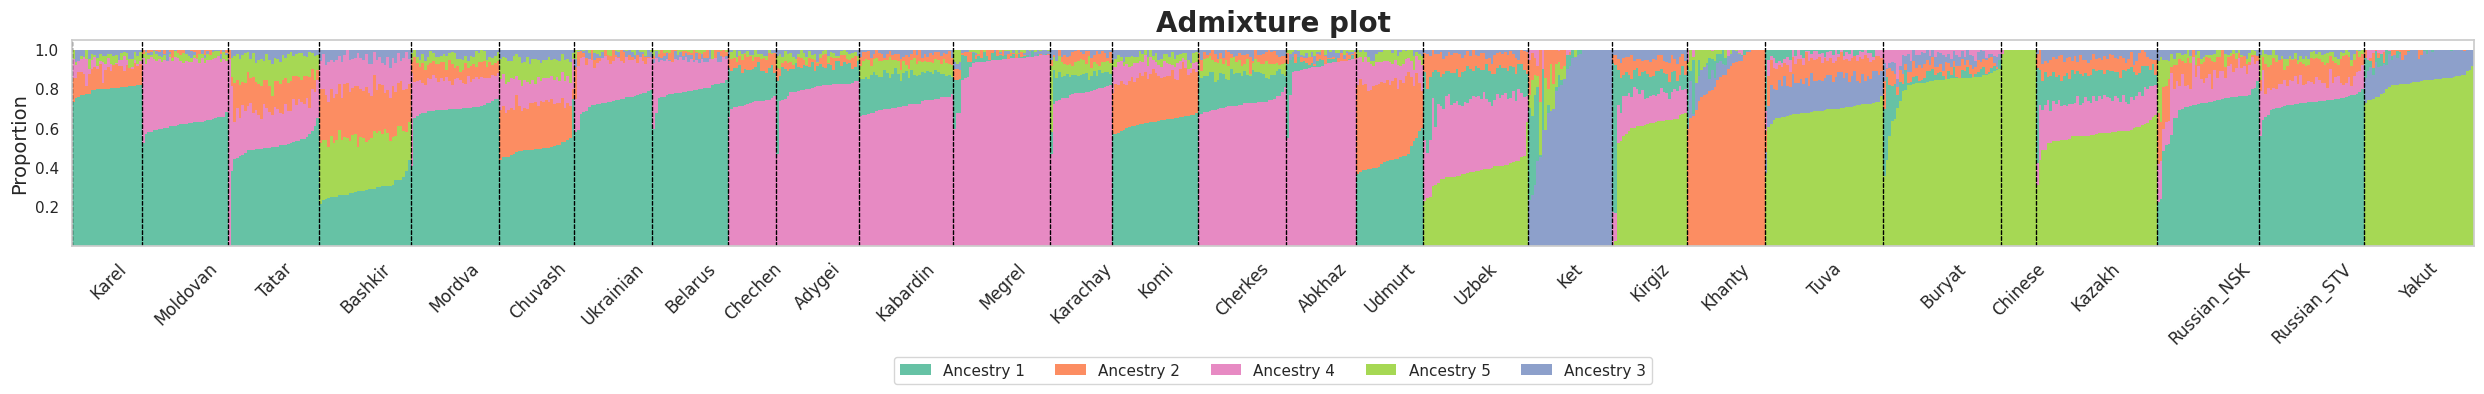

In [35]:
fig, ax = plt.subplots(figsize=(25, 5))

# Уникальные популяции
populations_unique = data_pop.Population.unique()
colors = sns.color_palette("Set2", n_colors=data_admixure.shape[1])
colors_mapping = {idx + 1: color for idx, color in enumerate(colors)}

# Смещение по оси X для разных популяций
x_offset = 0
tick_positions = []
tick_labels = []

for target_population in populations_unique:
    # Фильтруем данные для конкретной популяции
    data_pop_target = data_pop[data_pop.Population == target_population]
    data_target = data_admixure.loc[data_pop_target.index]
    
    # Сортируем
    data_target = data_target.sort_values(
        list(data_target.sum(axis=0).sort_values(ascending=False).index)
    )
    data_target = data_target.loc[:, list(data_target.sum(axis=0).sort_values(ascending=False).index)]
    
    # Строим столбчатую диаграмму
    bottom = np.zeros(data_target.shape[0])
    for h in range(data_target.shape[1]):
        ancestry = data_target.columns[h]
        ax.bar(
            x=np.arange(data_target.shape[0]) + x_offset, 
            height=data_target.iloc[:, h].values, 
            bottom=bottom, 
            width=1, 
            edgecolor="none", 
            color=colors_mapping[ancestry], 
            label=f"Ancestry {ancestry}" if target_population == populations_unique[0] else None
        )
        bottom += data_target.iloc[:, h].values

        ax.axvline(x=x_offset - 0.5, color="black", linestyle="--", linewidth=0.8, alpha=0.7)

    # Добавляем метки оси X
    tick_positions.append(x_offset + data_target.shape[0] // 2)
    tick_labels.append(target_population)
    
    # Сдвигаем x_offset
    x_offset += data_target.shape[0]

# Настройка оси X
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, fontsize=12, rotation=45)
ax.set_xlim(-0.5, x_offset - 0.5)

# Оформление графика
ax.set_title("Admixture plot", fontsize=20, weight="bold")
ax.set_ylabel("Proportion", fontsize=14)
ax.set_xlabel("")
ax.legend(bbox_to_anchor=(0.5, -0.5), loc="upper center", ncol=5)
ax.grid(False)

plt.tight_layout()
plt.show()

## PCA

In [36]:
pca = PCA(n_components=3)
data_admixure_transformed = pca.fit_transform(data_admixure)
data_admixure_transformed.shape

(894, 3)

In [37]:
pca.explained_variance_ratio_.sum()

0.9188770774143158

In [38]:
data_admixure_pca = pd.DataFrame({'PC1': data_admixure_transformed[:, 0],
                         'PC2': data_admixure_transformed[:, 1],
                         'PC3': data_admixure_transformed[:, 2],
                         'Population': data_pop.loc[data_admixure.index, 'Population'].values
                        })

data_admixure_pca.sample(5)

,PC1,PC2,PC3,Population
65,0.632757,-0.039691,0.028314,Tuva
843,-0.365163,-0.344303,-0.158841,Belarus
885,-0.310196,-0.506502,-0.096419,Karel
348,0.198255,0.181592,-0.061197,Uzbek
546,-0.300193,0.189103,-0.059309,Abkhaz


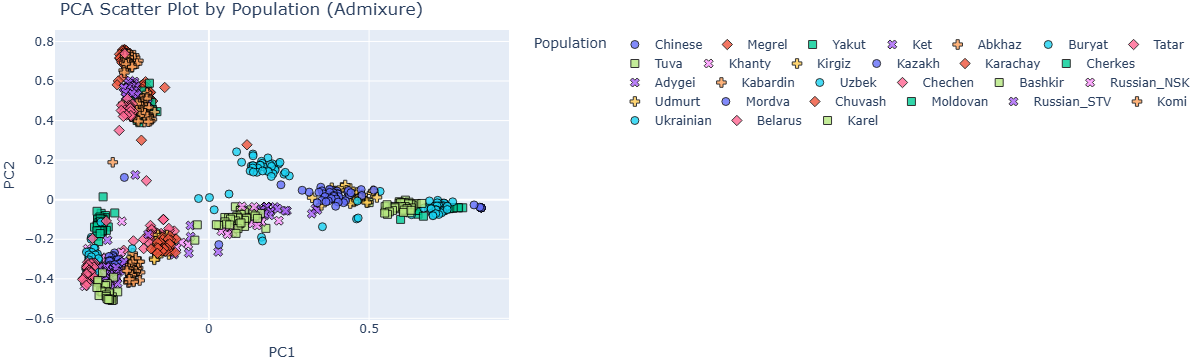

In [40]:
PREFIX = 'admixure_prop'
plot_2d(data=data_admixure_pca, title='PCA Scatter Plot by Population (Admixure)', x='PC1', y='PC2', save_name=f"{PREFIX}_2d_PCA")

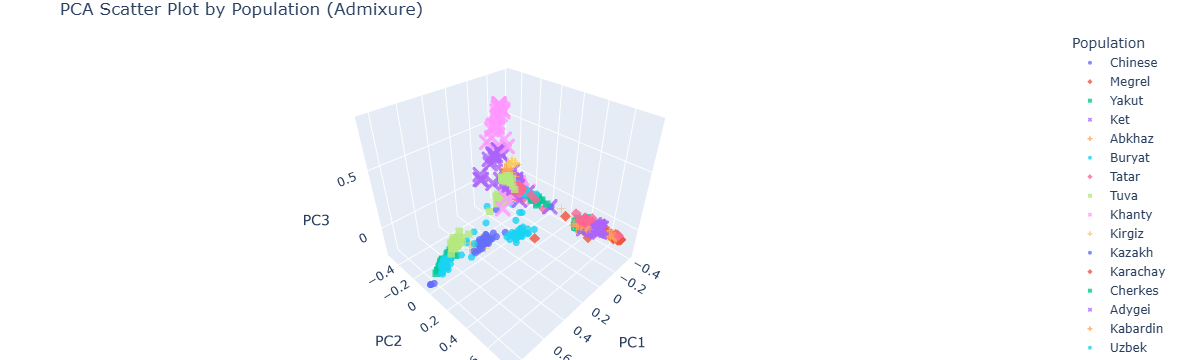

In [41]:
plot_3d(data=data_admixure_pca, title='PCA Scatter Plot by Population (Admixure)', x='PC1', y='PC2', z='PC3', save_name=f"{PREFIX}_3d_PCA")